In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from pathlib import Path
folder='./Helper_scripts/'

importLibs=1
for path in Path(folder).rglob('*.py'):
    print(path.name)
    exec(open(path).read())

parseCC.py
GetFrequencyFromZCfile.py
VariablesExperiment.py
importLibs0.py
FFT.py
DisplayAndCut.py


In [3]:
VariablesExperiment(20210727)

In [4]:
def FFT_ASCIIscope_mov2(scope_file,**kwargs):
    zeroN=kwargs.get('zeroN', 0)
    zeroNrel=kwargs.get('zeroNrel', None)
    start=kwargs.get('ti',0)
    end=kwargs.get('tf',100)
    window=kwargs.get('window','blackman')
    scope=pd.read_csv(scope_file,sep=",",skiprows=[0],names=['time','sig1'],header=0)
    filter=(scope['time']>start)&(scope['time']<end)
    scope=scope.loc[filter]
    N=scope.shape[0] #samples
    totalN = N+zeroN + zeroNrel*N
    y=scope['sig1']
    if(window=='blackman'):
        w=np.blackman(N)
        y=w*y
    T0=scope['time'].iloc[[0,-1]].diff().max()
    delta_f=1/T0
    f_max=(1/T0)*N//2
    yf = np.fft.fft(y,totalN)[:totalN//2]
    yf=1.0/N * np.abs(yf) #Absolute and Normalization
    xf = np.linspace(0.0, f_max,totalN//2 )
    print(N,totalN,xf[1],xf.shape,yf.shape)
    return xf,yf, delta_f, totalN

In [5]:
scope_dat['ti']=0.2
scope_dat['tf']=0.8

## Get Average electrical Frequency with FFT

In [6]:
scope_dat['index_copy']=scope_dat.index
for index, row in scope_dat.iterrows():    
    print(index)
    file=row['ScopeFile']
    xf,yf, delta_f, totalN=FFT_ASCIIscope_mov2(file,zeroNrel=25,ti=row['ti'],tf=row['tf']) #Zero Padding
    scope_dat.loc[index,'f_mag_max']=xf[np.where(yf.max()==yf)][0]
    scope_dat.loc[index,'m_fmax']=yf.max()

0
300000 7800000 0.06410258053912321 (3900000,) (3900000,)
1
300000 7800000 0.06410258053912321 (3900000,) (3900000,)
2
300000 7800000 0.06410258053912321 (3900000,) (3900000,)
3
300000 7800000 0.06410258053912321 (3900000,) (3900000,)
4
300000 7800000 0.06410258053912321 (3900000,) (3900000,)
5
300000 7800000 0.06410258053912321 (3900000,) (3900000,)
6
300000 7800000 0.06410258053912321 (3900000,) (3900000,)
7
300000 7800000 0.06410258053912321 (3900000,) (3900000,)
8
300000 7800000 0.06410258053912321 (3900000,) (3900000,)
9
300000 7800000 0.06410258053912321 (3900000,) (3900000,)


## Calculate U_RMS

In [7]:
for index, row in scope_dat.iterrows():
    scope=pd.read_csv(row['ScopeFile'],sep=",",skiprows=[0],names=['time','sig1'],header=0)
    filter=(scope['time']>row['ti'])&(scope['time']<(row['tf']))
    u=scope.loc[filter,'sig1']
    rms = np.sqrt(np.mean(u**2))
    #print(rms)
    scope_dat.loc[index,'U_rms']=rms

In [8]:
# normalize
scope_dat['u']=scope_dat['U_rms']/scope_dat['f_mag_max']*31

In [9]:
scope_dat.loc[:,['Symbol','u','f_mag_max']]

,Symbol,u,f_mag_max
0,Rotor_Deviated,27.972932,31.474367
1,Rotor_Deviated,28.011347,31.089752
2,Rotor_Deviated,28.065373,30.833341
3,Rotor_Deviated,27.953062,31.153854
4,Rotor_Deviated,27.965488,31.089752
5,parallel,28.362552,30.897444
6,parallel,28.427350,30.833341
7,parallel,28.374029,30.897444
8,parallel,28.343939,31.025649
9,parallel,28.408269,31.538470


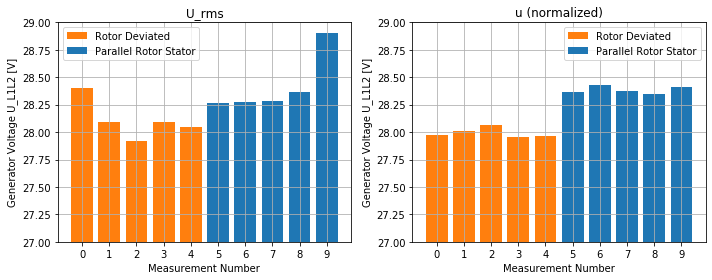

In [15]:
fig, ax0 = plt.subplots(1,2,figsize = (10,4))
#width=0.2
for i in range(2):
    ax=ax0[i]
    label1='Rotor Deviated'
    label2='Parallel Rotor Stator'
    x=np.arange(10)
    if(i==0):
        label_u='U_rms'
        label_ut=label_u
    if(i==1):
        label_u='u'
        label_ut='u (normalized)'
    data2=scope_dat.loc[scope_dat['Symbol']=='Rotor_Deviated',label_u]
    ax.bar(np.arange(len(data2)),data2,label=label1,color='C1')
    data2=scope_dat.loc[scope_dat['Symbol']=='parallel',label_u]
    bar_g=ax.bar(np.arange(len(data2))+5,data2,label=label2,color='C0')
    ax.set_ylim(27.0,29.0)
    ax.set_xticks(x)
    ax.legend()
    ax.set_title(label_ut)
    ax.set_xlabel('Measurement Number')
    ax.set_ylabel('Generator Voltage U_L1L2 [V]')
    ax.grid(True)
fig.tight_layout()
plt.savefig("U_RotorDeviated.svg",dpi=600)
plt.show()

## Calculate Voltage Reduction

In [11]:
scope_dat.loc[scope_dat['Symbol']=='parallel','u'].mean()-scope_dat.loc[scope_dat['Symbol']=='Rotor_Deviated','u'].mean()

0.3895874804771893

In [12]:
scope_dat.loc[scope_dat['Symbol']=='parallel','U_rms'].mean()

28.418502777662525